# Compute and save features for IFPEN data (test and train set)

In [1]:
#Chose Train or test set
TrainTest = "Train" # "Train" or "Test"

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gudhi as gd
import pickle
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder

from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects, erosion, skeletonize_3d

%matplotlib inline

#Paths 
CHALLENGE_PATH = "C:/Chazal/ChallengeIFPEN2018/"

if TrainTest == "Train":
    DATA_PATH = "C:/Chazal/ChallengeIFPEN2018/challenge_fichier_dentrees_dentrainement_prediction_de_la_saturation_dhuile_residuelle/Data/"
else:
    DATA_PATH = "C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/"

TOOLS_PATH = "C:/Chazal/ChallengeIFPEN2018/challenge_fichier_dentrees_dentrainement_prediction_de_la_saturation_dhuile_residuelle/Tools/"

#Some constants
DEFAULT_SIZE = [175,152,152]

if TrainTest == "Train":
    NB_INPUT_IMG = 400
    StartIdx = 0
else:
    NB_INPUT_IMG = 112
    StartIdx = 400

#Home made tools for persistence features
os.chdir("C:/Seafile/Ma bibliothèque/Chazal2/MyPython36") 
from DTM import *
#from persistent_surface import *
from PdiagFeatures import *

#Classes provided with the data 
os.chdir(TOOLS_PATH)
from Image3D import Image3D
from ImageIO import ImageIO

In [3]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix    
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression

### Functions to load the data and the output files

In [4]:
def load_outputs(output_path=CHALLENGE_PATH):
    csv_path = os.path.join(output_path,"challenge_fichier_de_sortie_dentrainement_prediction_de_la_saturation_dhuile_residuelle.csv")
    return pd.read_csv(csv_path,sep=';')

DEFAULT_SIZE = [175,152,152]

def load_data(data_path=DATA_PATH, nb_files=400, size=DEFAULT_SIZE):
    list_img3D = []
    for nb in range(StartIdx,StartIdx+NB_INPUT_IMG):
        file_name = data_path + "input_" + str(nb) + ".raw"
        io = ImageIO(file_name)
        img = io.read(size[0], size[1], size[2])
        list_img3D.append(img)
    return list_img3D

def load_output_data(data_path=DATA_PATH, nb_files=400, size=DEFAULT_SIZE):
    list_out_img3D = []
    for nb in range(StartIdx,StartIdx+NB_INPUT_IMG):
        file_name = data_path + "output_" + str(nb) + ".raw"
        io = ImageIO(file_name)
        img = io.read(size[0], size[1], size[2])
        list_out_img3D.append(img)
    return list_out_img3D

### Functions to extract images from the input data

#### Function to compute DTM from an image

In [5]:
#This function compute the DTM to the voxels with value different from void_id 

def img_DTM(img,kNN,void_id=1):
    buf = img.get_whole_array()
    pt_cloud = []
    query_pts = []
    for k in range(DEFAULT_SIZE[2]):
        for j in range(DEFAULT_SIZE[1]):
            for i in range(DEFAULT_SIZE[0]):
                query_pts.append([i,j,k])
                if buf[i,j,k] != void_id:
                    pt_cloud.append([i,j,k])
    pt_cloud = np.array(pt_cloud)
    list_DTM = DTM(pt_cloud,query_pts,kNN)
    buff = np.zeros((DEFAULT_SIZE[0],DEFAULT_SIZE[1],DEFAULT_SIZE[2]))
    it=0
    for k in range(DEFAULT_SIZE[2]):
        for j in range(DEFAULT_SIZE[1]):
            for i in range(DEFAULT_SIZE[0]):
                buff[i,j,k]=list_DTM[it]
                it +=1
    DTM_img = Image3D(buff)
    return DTM_img

#### Compute DTM images (slow!)

In [16]:
kNN = 1

for idx in range(StartIdx,StartIdx+NB_INPUT_IMG):
    img = list_img3D[idx-StartIdx]
    imgDTM = img_DTM(img,kNN)
    file_name = CHALLENGE_PATH + "DTM/" + "img_DTM" + str(kNN) + "_" + str(idx) + ".dat"    
    pickle.dump(imgDTM,open(file_name, "wb"))
    print("Image saved: ", idx)

Image saved:  400
Image saved:  401
Image saved:  402
Image saved:  403
Image saved:  404
Image saved:  405
Image saved:  406
Image saved:  407
Image saved:  408
Image saved:  409
Image saved:  410
Image saved:  411
Image saved:  412
Image saved:  413
Image saved:  414
Image saved:  415
Image saved:  416
Image saved:  417
Image saved:  418
Image saved:  419
Image saved:  420
Image saved:  421
Image saved:  422
Image saved:  423
Image saved:  424
Image saved:  425
Image saved:  426
Image saved:  427
Image saved:  428
Image saved:  429
Image saved:  430
Image saved:  431
Image saved:  432
Image saved:  433
Image saved:  434
Image saved:  435
Image saved:  436
Image saved:  437
Image saved:  438
Image saved:  439
Image saved:  440
Image saved:  441
Image saved:  442
Image saved:  443
Image saved:  444
Image saved:  445
Image saved:  446
Image saved:  447
Image saved:  448
Image saved:  449
Image saved:  450
Image saved:  451
Image saved:  452
Image saved:  453
Image saved:  454
Image save

#### Funtion to extract boundary points
Warning: pretty slow!

In [6]:
def boundary_extract(img):
    bd_img = Image3D(np.zeros((DEFAULT_SIZE[0],DEFAULT_SIZE[1],DEFAULT_SIZE[2])))
    max_idx = DEFAULT_SIZE[0]*DEFAULT_SIZE[1]*DEFAULT_SIZE[2]
    for id in range(max_idx):
        [i,j,k] = img.get_indices(id)
        val = img.get_value(i,j,k)
        if val == 0:
            nghb = img.neighbors(id)
            sum_val = 0
            for p in nghb:
                [i1,j1,k1] = img.get_indices(p)
                sum_val += img.get_value(i1,j1,k1)
            if sum_val > 0:
                #[i,j,k] = img.get_indices(id)
                bd_img.set_value(i,j,k,1)
    return bd_img

#### Compute boundary of input images

In [7]:
for idx in range(StartIdx,StartIdx+NB_INPUT_IMG):
    img = list_img3D[idx-StartIdx]
    imgBd = boundary_extract(img)
    file_name = CHALLENGE_PATH + "ImgBD/" + "imgBD_" + str(idx) + ".dat"    
    pickle.dump(imgBd,open(file_name, "wb"))
    print("Image saved: ", idx)

NameError: name 'list_img3D' is not defined

#### Compute and save local max of distance function (DTM1)
Warning this takes a moment

In [20]:
max_idx = DEFAULT_SIZE[0]*DEFAULT_SIZE[1]*DEFAULT_SIZE[2]
local_max_list = []
for idx in range(StartIdx,StartIdx+NB_INPUT_IMG):
    loc_max = []
    file_name_img = "img_DTM1_" + str(idx) + ".dat"
    img = pickle.load(open(CHALLENGE_PATH + "DTM/"+ file_name_img, "rb"),encoding="latin1")
    for id in range(max_idx):
        [i,j,k] = img.get_indices(id)
        val = img.get_value(i,j,k)
        nghb = img.neighbors(id)
        val_nghb = []
        for p in nghb:
            [i1,j1,k1] = img.get_indices(p)
            val_nghb.append(img.get_value(i1,j1,k1))
        if np.max(val_nghb) < val:
            loc_max.append([id,val])
    pickle.dump(loc_max,open(CHALLENGE_PATH + "DTM/loc_max_DTM1_"+ str(idx) + ".dat", "wb"))
    print("Local max computed for image: ", idx)
    local_max_list.append(loc_max)

Local max computed for image:  400
Local max computed for image:  401
Local max computed for image:  402
Local max computed for image:  403
Local max computed for image:  404
Local max computed for image:  405
Local max computed for image:  406
Local max computed for image:  407
Local max computed for image:  408
Local max computed for image:  409
Local max computed for image:  410
Local max computed for image:  411
Local max computed for image:  412
Local max computed for image:  413
Local max computed for image:  414
Local max computed for image:  415
Local max computed for image:  416
Local max computed for image:  417
Local max computed for image:  418
Local max computed for image:  419
Local max computed for image:  420
Local max computed for image:  421
Local max computed for image:  422
Local max computed for image:  423
Local max computed for image:  424
Local max computed for image:  425
Local max computed for image:  426
Local max computed for image:  427
Local max computed f

#### #To load input and output images + DTM images (if already computed)

In [8]:
def load_img_and_out_DTM(idx,kNN=1):  
    file_name_img = DATA_PATH + "input_" + str(idx) + ".raw"
    file_name_out = DATA_PATH + "output_" + str(idx) + ".raw"
    file_name_DTM = CHALLENGE_PATH + "DTM/img_DTM"+ str(kNN) +"_" + str(idx) + ".dat"
    io = ImageIO(file_name_img)
    img = io.read(DEFAULT_SIZE[0], DEFAULT_SIZE[1], DEFAULT_SIZE[2])
    io = ImageIO(file_name_out)
    img_out = io.read(DEFAULT_SIZE[0], DEFAULT_SIZE[1], DEFAULT_SIZE[2])
    DTM_img = pickle.load(open(file_name_DTM, "rb"),encoding="latin1")
    return img, img_out, DTM_img

def load_img_and_DTM(idx,kNN=1):  
    file_name_img = DATA_PATH + "input_" + str(idx) + ".raw"
    file_name_DTM = CHALLENGE_PATH + "DTM/img_DTM"+ str(kNN) +"_" + str(idx) + ".dat"
    io = ImageIO(file_name_img)
    img = io.read(DEFAULT_SIZE[0], DEFAULT_SIZE[1], DEFAULT_SIZE[2])
    DTM_img = pickle.load(open(file_name_DTM, "rb"),encoding="latin1")
    return img, DTM_img

## 2. Computation of basic features

### 2.1 Computation of volume of voids

In [22]:
#The list of input image must have been loaded in list_img3D
Feat_vol_voids = []
total_vol = DEFAULT_SIZE[0]*DEFAULT_SIZE[1]*DEFAULT_SIZE[2]
for idx in range(StartIdx,StartIdx+NB_INPUT_IMG):
    file_name_img = DATA_PATH + "input_" + str(idx) + ".raw"
    io = ImageIO(file_name_img)
    img = io.read(DEFAULT_SIZE[0], DEFAULT_SIZE[1], DEFAULT_SIZE[2])
    Feat_vol_voids.append(np.sum(img.get_whole_array())/(total_vol))
Feat_vol_voids = np.array(Feat_vol_voids)
if TrainTest == "Train":
    pickle.dump(Feat_vol_voids,open(CHALLENGE_PATH + "Feat_vol_voids.dat", "wb"))
else:
    pickle.dump(Feat_vol_voids,open(CHALLENGE_PATH + "Feat_vol_voids_test.dat", "wb"))

.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_400.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_401.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_402.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_403.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_404.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_405.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers

.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_477.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_478.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_479.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_480.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_481.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_482.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers

NameError: name 'TrainTestestestTest' is not defined

### 2.2 Compute the (normalized) sum of the values of the DTM in the void part of input images

In [26]:
kNN = 1

Feat_volDTM_voids = []
total_vol = DEFAULT_SIZE[0]*DEFAULT_SIZE[1]*DEFAULT_SIZE[2]
for idx in range(StartIdx,StartIdx+NB_INPUT_IMG):
    img, DTM_img =load_img_and_DTM(idx,kNN)
    buff = DTM_img.get_whole_array()
    buff_in_void = np.multiply(buff, img.get_whole_array())
    Feat_volDTM_voids.append(np.sum(buff_in_void)/(total_vol))
Feat_volDTM_voids = np.array(Feat_volDTM_voids)

if TrainTest == "Train":
    pickle.dump(Feat_volDTM_voids,open(CHALLENGE_PATH + "Feat_volDTM"+ str(kNN) +"_voids.dat", "wb"))
else:
    pickle.dump(Feat_volDTM_voids,open(CHALLENGE_PATH + "Feat_volDTM"+ str(kNN) +"_voids_test.dat", "wb"))
#Don't forget to rename the Feat_volDTM_voids variable if several values of kNN are considered

.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_400.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_401.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_402.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_403.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_404.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_405.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers

.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_456.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_457.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_458.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_459.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_460.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_461.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers

NameError: name 'TrainTestest' is not defined

### 2.3 Computation of the area (normalized) of the boundary of the voids

In [28]:
Feat_area_bd = []
normalize_factor = DEFAULT_SIZE[0]*DEFAULT_SIZE[1]
for idx in range(StartIdx,StartIdx+NB_INPUT_IMG):
    bdimg = pickle.load(open(CHALLENGE_PATH + "ImgBD/ImgBD_" + str(idx) + ".dat", "rb"),encoding="latin1")
    nb_pts = np.sum(bdimg.get_whole_array())
    Feat_area_bd.append(nb_pts/normalize_factor)
Feat_area_bd = np.array(Feat_area_bd)
Feat_area_bd =np.reshape(Feat_area_bd,(NB_INPUT_IMG,1))

if TrainTest == "Train":
    pickle.dump(Feat_area_bd,open(CHALLENGE_PATH + "Feat_area_bd.dat", "wb"))
else:
    pickle.dump(Feat_area_bd,open(CHALLENGE_PATH + "Feat_area_bd_test.dat", "wb"))

### 2.4 Getting the distribution of areas of voids of slices

In [29]:
### Getting the distribution of areas of voids of slices
Feat_vol_slices = []
total_area = DEFAULT_SIZE[1]*DEFAULT_SIZE[2]
for idx in range(StartIdx,StartIdx+NB_INPUT_IMG):
    areas = []
    file_name_img = DATA_PATH + "input_" + str(idx) + ".raw"
    io = ImageIO(file_name_img)
    img = io.read(DEFAULT_SIZE[0], DEFAULT_SIZE[1], DEFAULT_SIZE[2])
    for k in range(DEFAULT_SIZE[0]):
        areas.append(np.sum(img.get_plane(k))/total_area)
    Feat_vol_slices.append([np.mean(areas),np.std(areas)])
Feat_vol_slices = np.array(Feat_vol_slices)
if TrainTest == "Train":
    pickle.dump(Feat_vol_slices,open(CHALLENGE_PATH + "Voids_slices.dat", "wb"))
else:
    pickle.dump(Feat_vol_slices,open(CHALLENGE_PATH + "Voids_slices_test.dat", "wb"))

.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_400.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_401.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_402.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_403.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_404.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_405.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers

.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_465.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_466.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_467.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_468.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_469.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_470.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers

### 2.5 Getting the distribution of length of boundaries in slices

In [30]:
### Getting the distribution of length of boundaries in slices
Feat_length_slices = []
total_length = DEFAULT_SIZE[1]
for idx in range(StartIdx,StartIdx+NB_INPUT_IMG):
    lengths = []
    file_name_img = CHALLENGE_PATH + "ImgBD/ImgBD_" + str(idx) + ".dat"
    img = pickle.load(open(file_name_img, "rb"),encoding="latin1")
    for k in range(DEFAULT_SIZE[0]):
        lengths.append(np.sum(img.get_plane(k))/total_length)
    Feat_length_slices.append([np.mean(lengths),np.std(lengths)])
Feat_length_slices = np.array(Feat_length_slices)

if TrainTest == "Train":
    pickle.dump(Feat_length_slices,open(CHALLENGE_PATH + "Length_slices.dat", "wb"))
else:
    pickle.dump(Feat_length_slices,open(CHALLENGE_PATH + "Length_slices_test.dat", "wb"))

### 2.6 Compute histogram or percentiles of the distance values at local max of the distance function

In [31]:
#Compute percentiles of the distribution of the distance values of the local max
Feat_loc_max = []
list_loc_max = []
#percents = [10,20,30,40,50,60,70,80,90,95,98,99]

for idx in range(StartIdx,StartIdx+NB_INPUT_IMG):
    loc_max = pickle.load(open(CHALLENGE_PATH + "DTM/loc_max_DTM1_"+ str(idx) + ".dat", "rb"), encoding="latin1")
    loc_max = np.array(loc_max)
    list_loc_max.append(loc_max)
    #prc = []
    #for ip in percents:
    #    prc.append(np.percentile(loc_max[:,1],ip))
    hst = np.histogram(loc_max[:,1],bins=20)
    Feat_loc_max.append(np.concatenate([hst[0],hst[1]],axis=0))
Feat_loc_max = np.array(Feat_loc_max)

if TrainTest == "Train":
    pickle.dump(Feat_loc_max,open(CHALLENGE_PATH + "Feat_Locmax.dat", "wb"))
else:
    pickle.dump(Feat_loc_max,open(CHALLENGE_PATH + "Feat_Locmax_test.dat", "wb"))

### 2.7 Compute density of 3D images

In [32]:
def get_density(img, ngbh=2):
    buff = img.get_whole_array()
    vol_tot = (2*ngbh+1)*(2*ngbh+1)*(2*ngbh+1)
    density_img = Image3D(np.zeros((DEFAULT_SIZE[0],DEFAULT_SIZE[1],DEFAULT_SIZE[2])))
    for i in range(ngbh,DEFAULT_SIZE[0]-ngbh):
        for j in range(ngbh,DEFAULT_SIZE[1]-ngbh):
            for k in range(ngbh,DEFAULT_SIZE[2]-ngbh):
                density_img.set_value(j,k,i,np.sum(buff[i-ngbh:i+ngbh+1,j-ngbh:j+ngbh+1,k-ngbh:k+ngbh+1])/vol_tot)
    return density_img

In [33]:
for idx in range(StartIdx,StartIdx+NB_INPUT_IMG):
    img = list_img3D[idx-StartIdx]
    d_img = get_density(img,ngbh=2)
    filename = "SetDensity2_" + str(idx) + ".dat"
    pickle.dump(d_img, open(CHALLENGE_PATH + "SetDensity2/" + filename,"wb"))
    if idx%5 == 0:
        print(idx)

400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510


#### histograms of density values

In [34]:
nb_bins = 12
Feat_density_hist = []
for idx in range(StartIdx,StartIdx+NB_INPUT_IMG):
    filename = "SetDensity2_" + str(idx) + ".dat"
    d_img = pickle.load(open(CHALLENGE_PATH + "SetDensity2/" + filename, "rb"),encoding="latin1")
    hst = np.histogram(d_img.get_whole_array(),bins=nb_bins)
    tot = np.sum(hst[0][1:nb_bins-1]) #total number of pixels where the boundary value is different from extremal values (0 and 1).
    Feat_density_hist.append(hst[0][1:nb_bins-1]/tot) #numbers of voxels per bins are normalized
Feat_density_hist = np.array(Feat_density_hist)

#save the density histograms features 
if TrainTest == "Train":
    pickle.dump(Feat_density_hist,open(CHALLENGE_PATH + "SetDensity2_hist.dat", "wb"))
else:
    pickle.dump(Feat_density_hist,open(CHALLENGE_PATH + "SetDensity2_hist_test.dat", "wb"))

### 2.8 Features from skeleton

In [80]:
def get_skeleton(img):
    return skeletonize_3d(img)

Feat_skel =[]

for idx in range(StartIdx,StartIdx+NB_INPUT_IMG):
    skel_vals = []
    img, img_DTM = load_img_and_DTM(idx,kNN=1)
    buff_DTM = img_DTM.get_whole_array()
    skel = get_skeleton(img.get_whole_array())
    dist_skel = np.multiply(skel,buff_DTM)
    A = (dist_skel != 0)
    B = dist_skel[A]
    for i in range(25):
        skel_vals.append(np.sum(np.logical_and((B >=i), (B < i+1))))
    Feat_skel.append(skel_vals)
    if idx%40==0:
        print(idx)
    
Feat_skel = np.array(Feat_skel)
print(np.shape(Feat_skel))

#save the skeleton features 
if TrainTest == "Train":
    pickle.dump(Feat_skel,open(CHALLENGE_PATH + "Skeleton.dat", "wb"))
else:
    pickle.dump(Feat_skel,open(CHALLENGE_PATH + "Skeleton_test.dat", "wb"))       

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:118: UserWarning: Possible sign loss when converting negative image of type int8 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from int8 to uint8
  .format(dtypeobj_in, dtypeobj_out))


400
440
480
(112, 25)


In [112]:
#Test: to be removed
idx = 98
img, img_DTM = load_img_and_DTM(idx,kNN=1)
buff_DTM = img_DTM.get_whole_array()
skel = get_skeleton(img.get_whole_array())
dist_skel = np.multiply(skel,buff_DTM)
not_in_skel=0
not_in_skel_val = 30.0

lval = []
for k in range(DEFAULT_SIZE[2]):
    for j in range(DEFAULT_SIZE[1]):
        for i in range(DEFAULT_SIZE[0]):
            if dist_skel[i,j,k] != not_in_skel:
                lval.append(dist_skel[i,j,k])
            else:
                lval.append(not_in_skel_val) 
cub_cpx = gd.CubicalComplex(DEFAULT_SIZE,lval)
dgm = cub_cpx.persistence(homology_coeff_field=2, min_persistence=0)


C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:118: UserWarning: Possible sign loss when converting negative image of type int8 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from int8 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [69]:
#### Test: to be removed
idx = 294
img, img_DTM = load_img_and_DTM(idx,kNN=1)
buff_DTM = img_DTM.get_whole_array()
skel = skeletonize_3d(img.get_whole_array())

skel = remove_small_objects(skel.astype(bool),min_size=8)


pt_cloud = []
noise = 0.0001

for i in range(np.shape(skel)[0]):
    for j in range(np.shape(skel)[1]):
        for k in range(np.shape(skel)[2]):
            if skel[i,j,k] == True:
                pt_cloud.append([i,j,k]+noise*np.random.rand(3))
print(len(pt_cloud))

alpha_complex = gd.AlphaComplex(points=pt_cloud)
st = alpha_complex.create_simplex_tree(max_alpha_square=1000000000)
dgm = st.persistence(homology_coeff_field=2, min_persistence=0)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:118: UserWarning: Possible sign loss when converting negative image of type int8 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from int8 to uint8
  .format(dtypeobj_in, dtypeobj_out))


521


number of pairs in dim 0:  521
number of pairs in dim 1:  612
number of pairs in dim 2:  225
total number of pairs (for check):  1358
62.05464203011295


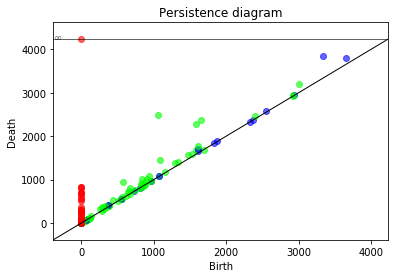

In [70]:
#### Test: to be removed
dgm0, dgm1, dgm2 = get_dgm_dim012(dgm,details=True)

#dgm_scale = []
#for pt in dgm:
#    dgm_scale.append((pt[0],(np.sqrt(pt[1][0]),np.sqrt(pt[1][1]))))

gd.plot_persistence_diagram(dgm,max_plots=1000)
val2 = []
for pt in dgm2:
    val2.append(pt[1][0])
    val2.append(pt[1][1])
print(np.sqrt(np.max(val2)))


## 3. Load all non persistence features

In [9]:
if TrainTest == "Test":
    Feat_vol_voids = pickle.load(open(CHALLENGE_PATH + "Feat_vol_voids_test.dat", "rb"), encoding="latin1")
    kNN=1
    Feat_volDTM_voids = pickle.load(open(CHALLENGE_PATH + "Feat_volDTM"+ str(kNN) +"_voids_test.dat", "rb"), encoding="latin1")
    Feat_area_bd = pickle.load(open(CHALLENGE_PATH + "Feat_area_bd_test.dat", "rb"), encoding="latin1")
    Feat_vol_slices = pickle.load(open(CHALLENGE_PATH + "Voids_slices_test.dat", "rb"), encoding="latin1")
    Feat_length_slices = pickle.load(open(CHALLENGE_PATH + "Length_slices_test.dat","rb"),encoding="latin1")
    Feat_loc_max = pickle.load(open(CHALLENGE_PATH + "Feat_Locmax_test.dat", "rb"),encoding="latin1")
    Feat_density_hist = pickle.load(open(CHALLENGE_PATH + "SetDensity2_hist_test.dat", "rb"),encoding="latin1")
    Feat_skel = pickle.load(open(CHALLENGE_PATH + "Skeleton_test.dat", "rb"),encoding="latin1")
else:
    Feat_vol_voids = pickle.load(open(CHALLENGE_PATH + "Feat_vol_voids.dat", "rb"), encoding="latin1")
    kNN=1
    Feat_volDTM_voids = pickle.load(open(CHALLENGE_PATH + "Feat_volDTM"+ str(kNN) +"_voids.dat", "rb"), encoding="latin1")
    Feat_area_bd = pickle.load(open(CHALLENGE_PATH + "Feat_area_bd.dat", "rb"), encoding="latin1")
    Feat_vol_slices = pickle.load(open(CHALLENGE_PATH + "Voids_slices.dat", "rb"), encoding="latin1")
    Feat_length_slices = pickle.load(open(CHALLENGE_PATH + "Length_slices.dat","rb"),encoding="latin1")
    Feat_loc_max = pickle.load(open(CHALLENGE_PATH + "Feat_Locmax.dat", "rb"),encoding="latin1")
    Feat_density_hist = pickle.load(open(CHALLENGE_PATH + "SetDensity2_hist.dat", "rb"),encoding="latin1")
    Feat_skel = pickle.load(open(CHALLENGE_PATH + "Skeleton.dat", "rb"),encoding="latin1")

## 4. Persistence diagrams

### 4.1Functions to compute persistence

In [21]:
#Function to compute persistence on cubical complexes
def persist_img(img):
    buf = img.get_whole_array()
    lval = []
    for k in range(DEFAULT_SIZE[2]):
        for j in range(DEFAULT_SIZE[1]):
            for i in range(DEFAULT_SIZE[0]):
                lval.append(buf[i,j,k]) 
    cub_cpx = gd.CubicalComplex(DEFAULT_SIZE,lval)
    return cub_cpx, cub_cpx.persistence(homology_coeff_field=2, min_persistence=0)

In [22]:
#Function to compute persistence
def persist_img_fn(img, fn, void_id=1, void_val=1000): #void_id has to be the value taken by img at the "void" points 
    buf = img.get_whole_array()
    lval = []
    for k in range(DEFAULT_SIZE[2]):
        for j in range(DEFAULT_SIZE[1]):
            for i in range(DEFAULT_SIZE[0]):
                if buf[i,j,k]==void_id :
                    lval.append(void_val)
                else:
                    lval.append(fn(i,j,k)) 
    cub_cpx = gd.CubicalComplex(DEFAULT_SIZE,lval)
    return cub_cpx, cub_cpx.persistence(homology_coeff_field=2, min_persistence=0)

#Persistence for the z-coordinate
def fn_z(i,j,k):
    return k

def fn_x(i,j,k):
    return i

def fn_y(i,j,k):
    return j

### 4.2 Various function to deal with diagrams and compute persistence images

#### To get diagrams per dimension

In [23]:
def get_dgm_dim012(dgm,details=False):
    dgm0 = []
    dgm1 = []
    dgm2 = []
    for p in dgm:
        if (p[0]==0):
            dgm0.append(p)
        elif (p[0]==1):
            dgm1.append(p)
        elif (p[0]==2):
            dgm2.append(p)
    if details == True:
        print("number of pairs in dim 0: ", len(dgm0))
        print("number of pairs in dim 1: ", len(dgm1))
        print("number of pairs in dim 2: ", len(dgm2))
        #print("number of pairs in dim 3: ", len(dgm3))
        print("total number of pairs (for check): ", len(dgm0)+len(dgm1)+len(dgm2))
    return dgm0, dgm1, dgm2

In [24]:
def get_list_dgm_per_dim(list_dgm):
    list_dgm0 =[]
    list_dgm1 =[]
    list_dgm2 =[]
    for dgm in list_dgm:
        dgm0, dgm1, dgm2 = get_dgm_dim012(dgm)
        list_dgm0.append(dgm0)
        list_dgm1.append(dgm1)
        list_dgm2.append(dgm2)
    return list_dgm0, list_dgm1, list_dgm2

#### Remove the dimension in persistence diagrams + essential part to prepare for persistence images computation

In [25]:
def remove_essential(dgm,max_death=np.inf):
    dgm_ne =[]
    for p in dgm:
        if (p[1][1] < max_death):
                dgm_ne.append(p)
    return dgm_ne



In [26]:
def remove_dim_and_essential(list_dgm, max_death=np.inf):
    list_dgm_nd = []   #for dim 0, also remove the point with infinite persistence
    for dgm in list_dgm:
        dgm_nd = []
        for p in dgm:
            if (p[1][1] < max_death):
                dgm_nd.append(p[1])
        list_dgm_nd.append(dgm_nd)
    return list_dgm_nd

#### To help to chose bounds in persistence images

In [71]:
def plot_dgm(list_dgm,idx,max_pts=100):
    gd.plot_persistence_diagram(list_dgm[idx],max_plots=max_pts)
    print("number of points in diagram: ", len(list_dgm[idx]))
    print("Material: ", outputs["material"][idx])

#### Functions to compute persistence images

In [72]:
def weight_fn(x,y):
    return np.abs(y)   #y*y for DTM (DTM30)

def get_persistence_images(list_dgm_nd,x_min,x_max,nb_x_step,y_min,y_max,nb_y_step,sigma2, weight=weight_fn):
    Feat_pers = []
    Pers_img = []
    for dgm in list_dgm_nd:
        X,Y,IPers = persistence_surf(dgm,x_min,x_max,nb_x_step,y_min,y_max,nb_y_step,sigma2,\
                          weight=weight_fn)
        Pers_img.append(IPers)
        Feat_pers.append(np.ravel(IPers))
    Feat_pers = np.array(Feat_pers)
    return Feat_pers, Pers_img

### Functions to load already computed images, persistence diagrams

In [79]:
#To load persistence diagrams of DTM function
def load_DTM_dgm(idx,kNN=1):
    file_name_dgm = CHALLENGE_PATH + "DTM/dgm_DTM" + str(kNN) + "_" + str(idx) + ".dat"
    return pickle.load(open(file_name_dgm, "rb"), encoding="latin1")

#To get all DTM diagrams
def load_all_DTM_dgm(kNN=1):
    list_dgm_DTM = []
    for idx in range(StartIdx,StartIdx+NB_INPUT_IMG):
        list_dgm_DTM.append(load_DTM_dgm(idx,kNN))
    return list_dgm_DTM

#To load the persistence diagrams of the alpha-shape filtration built on the local max of distance function (DTM1)
def load_all_dgm_loc_max():
    list_loc_max_dgm = []
    for idx in range(StartIdx,StartIdx+NB_INPUT_IMG):
        file_name_dgm = "dgm_loc_max_" + str(idx) + ".dat"
        dgm = pickle.load(open(CHALLENGE_PATH + "DTM/"+ file_name_dgm, "rb"),encoding="latin1")
        list_loc_max_dgm.append(dgm)
    return list_loc_max_dgm


#To load persistence diagrams of the distance function on the Delaunay triang built on top of local max
def load_all_dgm_locmax_dist():
    list_locmax_dist_dgm = []
    for idx in range(StartIdx,StartIdx+NB_INPUT_IMG):
        dgm = pickle.load(open(CHALLENGE_PATH + "LocMaxDist/dgm_loc_max_dist" + str(idx) + ".dat", "rb"), encoding="latin1")
        list_locmax_dist_dgm.append(dgm)
    return list_locmax_dist_dgm

#To load persistence diagrams of the SetIntensity function
def load_all_dgm_SetIntensity2():
    list_intensity2_dgm = []
    for idx in range(StartIdx,StartIdx+NB_INPUT_IMG):
        file_dgm=  "dgm_SetDensity2_" + str(idx) + ".dat"
        dgm = pickle.load(open(CHALLENGE_PATH + "SetDensity2/" + file_dgm,"rb"),encoding="latin1")
        list_intensity2_dgm.append(dgm)
    return list_intensity2_dgm

#To load persistence diagrams of the height functions
def load_all_dgm_height(coord="X"):
    if coord == "X":
        file_path = CHALLENGE_PATH + "DgmX/"
    elif coord == "Y":
        file_path = CHALLENGE_PATH + "DgmY/"
    elif coord == "Z":
        file_path = CHALLENGE_PATH + "DgmZ/"
    else :
        print("Problem! Chose a correct value for coord")
    list_dgm = []
    for idx in  range(StartIdx,StartIdx+NB_INPUT_IMG):
        file_name = "dgm_" + str(idx) + ".dat"
        dgm = pickle.load(open(file_path + file_name,"rb"),encoding="latin1")
        list_dgm.append(dgm)
    return list_dgm

#To load persistence diagrams of alpha-complex filtration on skeleton
def load_all_dgm_skel():
    list_skel_dgm = []
    for idx in range(StartIdx,StartIdx+NB_INPUT_IMG):
        file_dgm = "dgm_skel" + str(idx) + ".dat"
        dgm = pickle.load(open(CHALLENGE_PATH + "Skeleton/" + file_dgm, "rb"),encoding="latin1")
        list_skel_dgm.append(dgm)
    return list_skel_dgm

### 4.2 Compute persistence diagrams of DTM1 (indeed 30 - DTM1)

In [46]:
kNN = 1
MAX_INV = 30

for nb in range(StartIdx,StartIdx+NB_INPUT_IMG):
    file_name = "img_DTM" + str(kNN) + "_" + str(nb) + ".dat"
    DTM_img = pickle.load(open(CHALLENGE_PATH + "DTM/"+ file_name, "rb"),encoding="latin1")
    DTM_img_inv = Image3D(MAX_INV - DTM_img.get_whole_array())
    cub_cpx, dgm = persist_img(DTM_img_inv)
    file_name_dgm = "dgm_DTM" + str(kNN) + "_" + str(nb) + ".dat"
    pickle.dump(dgm,open(CHALLENGE_PATH + "DTM/"+ file_name_dgm, "wb"))
    print("DTM dgm computed: ", nb)

DTM dgm computed:  400
DTM dgm computed:  401
DTM dgm computed:  402
DTM dgm computed:  403
DTM dgm computed:  404
DTM dgm computed:  405
DTM dgm computed:  406
DTM dgm computed:  407
DTM dgm computed:  408
DTM dgm computed:  409
DTM dgm computed:  410
DTM dgm computed:  411
DTM dgm computed:  412
DTM dgm computed:  413
DTM dgm computed:  414
DTM dgm computed:  415
DTM dgm computed:  416
DTM dgm computed:  417
DTM dgm computed:  418
DTM dgm computed:  419
DTM dgm computed:  420
DTM dgm computed:  421
DTM dgm computed:  422
DTM dgm computed:  423
DTM dgm computed:  424
DTM dgm computed:  425
DTM dgm computed:  426
DTM dgm computed:  427
DTM dgm computed:  428
DTM dgm computed:  429
DTM dgm computed:  430
DTM dgm computed:  431
DTM dgm computed:  432
DTM dgm computed:  433
DTM dgm computed:  434
DTM dgm computed:  435
DTM dgm computed:  436
DTM dgm computed:  437
DTM dgm computed:  438
DTM dgm computed:  439
DTM dgm computed:  440
DTM dgm computed:  441
DTM dgm computed:  442
DTM dgm com

### 4.3 Computation of the persistence diagrams of the intensity function

In [47]:
for idx in range(StartIdx,StartIdx+NB_INPUT_IMG):
    filename = "SetDensity2_" + str(idx) + ".dat"
    img = pickle.load(open(CHALLENGE_PATH + "SetDensity2/" + filename,"rb"),encoding="latin1")
    cub_cpx, dgm = persist_img(img)
    file_dgm=  "dgm_SetDensity2_" + str(idx) + ".dat"
    pickle.dump(dgm,open(CHALLENGE_PATH + "SetDensity2/" + file_dgm,"wb"))
    print("Dgm computed:", idx)

Dgm computed: 400
Dgm computed: 401
Dgm computed: 402
Dgm computed: 403
Dgm computed: 404
Dgm computed: 405
Dgm computed: 406
Dgm computed: 407
Dgm computed: 408
Dgm computed: 409
Dgm computed: 410
Dgm computed: 411
Dgm computed: 412
Dgm computed: 413
Dgm computed: 414
Dgm computed: 415
Dgm computed: 416
Dgm computed: 417
Dgm computed: 418
Dgm computed: 419
Dgm computed: 420
Dgm computed: 421
Dgm computed: 422
Dgm computed: 423
Dgm computed: 424
Dgm computed: 425
Dgm computed: 426
Dgm computed: 427
Dgm computed: 428
Dgm computed: 429
Dgm computed: 430
Dgm computed: 431
Dgm computed: 432
Dgm computed: 433
Dgm computed: 434
Dgm computed: 435
Dgm computed: 436
Dgm computed: 437
Dgm computed: 438
Dgm computed: 439
Dgm computed: 440
Dgm computed: 441
Dgm computed: 442
Dgm computed: 443
Dgm computed: 444
Dgm computed: 445
Dgm computed: 446
Dgm computed: 447
Dgm computed: 448
Dgm computed: 449
Dgm computed: 450
Dgm computed: 451
Dgm computed: 452
Dgm computed: 453
Dgm computed: 454
Dgm comput

### 4.4 Computation of the persistence diagrams of the X, Y and Z functions 

In [50]:
fn = fn_x
folder = "dgmX/"

for idx in range(StartIdx,StartIdx+NB_INPUT_IMG):
    file_name = DATA_PATH + "input_" + str(idx) + ".raw"
    io = ImageIO(file_name)
    img = io.read(DEFAULT_SIZE[0], DEFAULT_SIZE[1], DEFAULT_SIZE[2])
    cub_cpx, dgm = persist_img_fn(img,fn,void_id=1,void_val=200)
    file_dgm = "dgm_" + str(idx) + ".dat"
    pickle.dump(dgm,open(CHALLENGE_PATH + folder + file_dgm,"wb"))
    if (idx % 5 ==0):
        print("Dgm computed:", idx)

.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_400.raw with dim 175x152x152
Dgm computed: 400
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_401.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_402.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_403.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_404.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_405.raw with dim 175x152x152
Dgm computed: 405
.read file C:/Chazal/C

.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_452.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_453.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_454.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_455.raw with dim 175x152x152
Dgm computed: 455
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_456.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_457.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/

.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_504.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_505.raw with dim 175x152x152
Dgm computed: 505
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_506.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_507.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_508.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/challenge_fichiers_dentrees_de_test_prediction_de_la_saturation_dhuile_residuelle/input_509.raw with dim 175x152x152
.read file C:/Chazal/ChallengeIFPEN2018/

In [ ]:
fn = fn_y
folder = "dgmY/"

for idx in range(StartIdx,StartIdx+NB_INPUT_IMG):
    file_name = DATA_PATH + "input_" + str(idx) + ".raw"
    io = ImageIO(file_name)
    img = io.read(DEFAULT_SIZE[0], DEFAULT_SIZE[1], DEFAULT_SIZE[2])
    cub_cpx, dgm = persist_img_fn(img,fn,void_id=1,void_val=200)
    file_dgm = "dgm_" + str(idx) + ".dat"
    pickle.dump(dgm,open(CHALLENGE_PATH + folder + file_dgm,"wb"))
    if (idx % 5 ==0):
        print("Dgm computed:", idx)

In [ ]:
fn = fn_z
folder = "dgmZ/"

for idx in range(StartIdx,StartIdx+NB_INPUT_IMG):
    file_name = DATA_PATH + "input_" + str(idx) + ".raw"
    io = ImageIO(file_name)
    img = io.read(DEFAULT_SIZE[0], DEFAULT_SIZE[1], DEFAULT_SIZE[2])
    cub_cpx, dgm = persist_img_fn(img,fn,void_id=1,void_val=200)
    file_dgm = "dgm_" + str(idx) + ".dat"
    pickle.dump(dgm,open(CHALLENGE_PATH + folder + file_dgm,"wb"))
    if (idx % 5 ==0):
        print("Dgm computed:", idx)

### 4.5 Computation of the persistence diagrams of the alpha-complex built on top of the local max of DTM1 + DTM1 on the vertices of the Delaunay triang built on top of the local max of DTM1

In [ ]:
#Compute persistence of the alpha-complex built on top of local max
noise = 0.001
list_loc_max_dgm = []
img = Image3D(np.zeros((DEFAULT_SIZE[0],DEFAULT_SIZE[1],DEFAULT_SIZE[2])))
for idx in range(StartIdx,StartIdx+NB_INPUT_IMG):
    loc_max = pickle.load(open(CHALLENGE_PATH + "DTM/loc_max_DTM1_"+ str(idx) + ".dat", "rb"), encoding="latin1")
    loc_max = np.array(loc_max)
    pt_cloud = []
    for id in loc_max[:,0]:
        [i,j,k] = img.get_indices(id)
        pt_cloud.append([i,j,k]+noise*np.random.rand(3))
    alpha_complex = gd.AlphaComplex(points=pt_cloud)
    st = alpha_complex.create_simplex_tree(max_alpha_square=1000000000)
    dgm = st.persistence(homology_coeff_field=2, min_persistence=0)
    file_name_dgm = "dgm_loc_max_" + str(idx) + ".dat"
    pickle.dump(dgm,open(CHALLENGE_PATH + "LocMaxDist/"+ file_name_dgm, "wb"))
    list_loc_max_dgm.append(dgm)
    print("Loc max dgm computed: ", idx)

In [ ]:
#Compute persistence of the distance function on the Delaunay triang built on top of local max
noise = 0.001
list_locmax_dist_dgm = []
img = Image3D(np.zeros((DEFAULT_SIZE[0],DEFAULT_SIZE[1],DEFAULT_SIZE[2])))
for idx in range(StartIdx,StartIdx+NB_INPUT_IMG):
    loc_max = pickle.load(open(CHALLENGE_PATH + "DTM/loc_max_DTM1_"+ str(idx) + ".dat", "rb"), encoding="latin1")
    loc_max = np.array(loc_max)
    pt_cloud = []
    F = []
    for id in range(len(loc_max[:,0])):
        [i,j,k] = img.get_indices(loc_max[id,0])
        pt_cloud.append([i,j,k]+noise*np.random.rand(3))
        F.append(30 - loc_max[id,1])
    alpha_complex = gd.AlphaComplex(points=pt_cloud)
    st = alpha_complex.create_simplex_tree(max_alpha_square=1000000000)
    st_new = gd.SimplexTree()
    L = st.get_filtration()
    for splx in L:
        fval = np.max([F[i] for i in splx[0]])
        st_new.insert(splx[0],filtration=fval)
    dgm = st_new.persistence(homology_coeff_field=2, min_persistence=0)
    file_name_dgm = "dgm_loc_max_dist" + str(idx) + ".dat"
    pickle.dump(dgm,open(CHALLENGE_PATH + "LocMaxDist/"+ file_name_dgm, "wb"))
    list_locmax_dist_dgm.append(dgm)
    print("Loc max dgm computed: ", idx)

### 4.6 Computation of the persistence diagrams of the alpha-complex filtration on the skeleton

In [74]:
noise = 0.0001
list_skel_dgm = []
for idx in range(StartIdx,StartIdx+NB_INPUT_IMG):
    img, img_DTM = load_img_and_DTM(idx,kNN=1)
    skel = skeletonize_3d(img.get_whole_array())
    skel = remove_small_objects(skel.astype(bool),min_size=8)
    pt_cloud = []
    for i in range(np.shape(skel)[0]):
        for j in range(np.shape(skel)[1]):
            for k in range(np.shape(skel)[2]):
                if skel[i,j,k] == True:
                    pt_cloud.append([i,j,k]+noise*np.random.rand(3))
    alpha_complex = gd.AlphaComplex(points=pt_cloud)
    st = alpha_complex.create_simplex_tree(max_alpha_square=1000000000)
    dgm = st.persistence(homology_coeff_field=2, min_persistence=0)
    file_name_dgm = "dgm_skel" + str(idx) + ".dat"
    pickle.dump(dgm,open(CHALLENGE_PATH + "Skeleton/"+ file_name_dgm, "wb"))
    list_skel_dgm.append(dgm)
    print("Nb of points: ", len(pt_cloud), "dgm number: ", idx)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:118: UserWarning: Possible sign loss when converting negative image of type int8 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from int8 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Nb of points:  277 dgm number:  0
Nb of points:  729 dgm number:  1
Nb of points:  195 dgm number:  2
Nb of points:  1112 dgm number:  3
Nb of points:  691 dgm number:  4
Nb of points:  323 dgm number:  5
Nb of points:  361 dgm number:  6
Nb of points:  2262 dgm number:  7
Nb of points:  180 dgm number:  8
Nb of points:  630 dgm number:  9
Nb of points:  761 dgm number:  10
Nb of points:  1407 dgm number:  11
Nb of points:  523 dgm number:  12
Nb of points:  1238 dgm number:  13
Nb of points:  151 dgm number:  14
Nb of points:  833 dgm number:  15
Nb of points:  623 dgm number:  16
Nb of points:  309 dgm number:  17
Nb of points:  5494 dgm number:  18
Nb of points:  289 dgm number:  19
Nb of points:  447 dgm number:  20
Nb of points:  1177 dgm number:  21
Nb of points:  232 dgm number:  22
Nb of points:  1269 dgm number:  23
Nb of points:  916 dgm number:  24
Nb of points:  1314 dgm number:  25
Nb of points:  2751 dgm number:  26
Nb of points:  239 dgm number:  27
Nb of points:  899 dg

Nb of points:  402 dgm number:  229
Nb of points:  1997 dgm number:  230
Nb of points:  1309 dgm number:  231
Nb of points:  607 dgm number:  232
Nb of points:  1767 dgm number:  233
Nb of points:  303 dgm number:  234
Nb of points:  242 dgm number:  235
Nb of points:  824 dgm number:  236
Nb of points:  255 dgm number:  237
Nb of points:  219 dgm number:  238
Nb of points:  213 dgm number:  239
Nb of points:  997 dgm number:  240
Nb of points:  352 dgm number:  241
Nb of points:  1609 dgm number:  242
Nb of points:  1231 dgm number:  243
Nb of points:  174 dgm number:  244
Nb of points:  223 dgm number:  245
Nb of points:  259 dgm number:  246
Nb of points:  217 dgm number:  247
Nb of points:  469 dgm number:  248
Nb of points:  454 dgm number:  249
Nb of points:  157 dgm number:  250
Nb of points:  352 dgm number:  251
Nb of points:  714 dgm number:  252
Nb of points:  198 dgm number:  253
Nb of points:  809 dgm number:  254
Nb of points:  233 dgm number:  255
Nb of points:  215 dgm 

## 5. Compute (and save) persistence images

### 5.1 Getting DTM1 diagrams and images

In [51]:
list_dgm_DTM1 = load_all_DTM_dgm(kNN=1)

In [52]:
#For DTM1, prepare lists of diagrams
list_dgm0, list_dgm1, list_dgm2 = get_list_dgm_per_dim(list_dgm_DTM1)
list_dgm0_nd = remove_dim_and_essential(list_dgm0, max_death=np.inf)
list_dgm1_nd = remove_dim_and_essential(list_dgm1, max_death=np.inf)
list_dgm2_nd = remove_dim_and_essential(list_dgm2, max_death=np.inf)

In [53]:
#Persistence images for DTM1 in dim 0
nb_x_step = 6 #6
nb_y_step = 5  #5
ratio_sigma = 4 #4

x_min = 20 #27.8
x_max = 27 #28.8
y_min = 0.0 #0.0
y_max = 5.5 #1.0

sigma2 = ( (x_max-x_min) / ratio_sigma) * ( (y_max - y_min) / ratio_sigma)

Feat_DTM1_pers0, Pers_img_DTM1_0 = get_persistence_images(list_dgm0_nd,x_min,x_max,nb_x_step,y_min,y_max,nb_y_step,sigma2,\
                                                          weight=weight_fn)

file_name_dgm = "Feat_DTM1_pers0_test.dat"
pickle.dump(Feat_DTM1_pers0,open(CHALLENGE_PATH + file_name_dgm, "wb"))

In [54]:
#Persistence images for DTM1 in dim 1
nb_x_step = 6 #6
nb_y_step = 5  #5
ratio_sigma = 4 #4

x_min = 25 #27.8
x_max = 28.8 #28.8
y_min = 0.0 #0.0
y_max = 2.5 #1.0

sigma2 = ( (x_max-x_min) / ratio_sigma) * ( (y_max - y_min) / ratio_sigma)

Feat_DTM1_pers1, Pers_img_DTM1_1 = get_persistence_images(list_dgm1_nd,x_min,x_max,nb_x_step,y_min,y_max,nb_y_step,sigma2,\
                                                          weight=weight_fn)

file_name_dgm = "Feat_DTM1_pers1_test.dat"
pickle.dump(Feat_DTM1_pers1,open(CHALLENGE_PATH + file_name_dgm, "wb"))

In [58]:
#Persistence images for DTM1 in dim 2
nb_x_step = 6 #6
nb_y_step = 5  #5
ratio_sigma = 4 #4

x_min = 27.8 #27.8
x_max = 28.8 #28.8
y_min = 0.0 #0.0
y_max = 0.5 #1.0

sigma2 = ( (x_max-x_min) / ratio_sigma) * ( (y_max - y_min) / ratio_sigma)

Feat_DTM1_pers2, Pers_img_DTM1_2 = get_persistence_images(list_dgm2_nd,x_min,x_max,nb_x_step,y_min,y_max,nb_y_step,sigma2,\
                                                          weight=weight_fn)

file_name_dgm = "Feat_DTM1_pers2_test.dat"
pickle.dump(Feat_DTM1_pers2,open(CHALLENGE_PATH + file_name_dgm, "wb"))

### 5.2 Getting persistence diagrams and image for Density2

In [56]:
list_intensity2_dgm = load_all_dgm_SetIntensity2()

In [57]:
#Getting all diagrams per dimension and removing dimension and essential part
list_dgm0, list_dgm1, list_dgm2 = get_list_dgm_per_dim(list_intensity2_dgm)
list_dgm0_nd = remove_dim_and_essential(list_dgm0, max_death=np.inf)
list_dgm1_nd = remove_dim_and_essential(list_dgm1, max_death=np.inf)
list_dgm2_nd = remove_dim_and_essential(list_dgm2, max_death=np.inf)

In [59]:
#Persistence images in dim 0
nb_x_step = 6#6
nb_y_step = 5  #5
ratio_sigma = 4 #4

x_min = 0.0 
x_max = 1.0 
y_min = 0.0 
y_max = 1.0 

sigma2 = ( (x_max-x_min) / ratio_sigma) * ( (y_max - y_min) / ratio_sigma)

Feat_SetIntensity2_pers0, Pers_img_SetIntensity2_0 = get_persistence_images(list_dgm0_nd,x_min,x_max,nb_x_step,\
                                                                            y_min,y_max,nb_y_step,sigma2, weight=weight_fn)

file_name_dgm = "Feat_SetIntensity2_pers0_test.dat"
pickle.dump(Feat_SetIntensity2_pers0,open(CHALLENGE_PATH + file_name_dgm, "wb"))

In [60]:
#Persistence images in dim 1
nb_x_step = 6 #6
nb_y_step = 5  #5
ratio_sigma = 4 #4

x_min = 0.0 
x_max = 1.0 
y_min = 0.0 
y_max = 1.0 

sigma2 = ( (x_max-x_min) / ratio_sigma) * ( (y_max - y_min) / ratio_sigma)

Feat_SetIntensity2_pers1, Pers_img_SetIntensity2_1 = get_persistence_images(list_dgm1_nd,x_min,x_max,nb_x_step,\
                                                                            y_min,y_max,nb_y_step,sigma2, weight=weight_fn)

file_name_dgm = "Feat_SetIntensity2_pers1_test.dat"
pickle.dump(Feat_SetIntensity2_pers1,open(CHALLENGE_PATH + file_name_dgm, "wb"))

In [61]:
#Persistence images in dim 2
nb_x_step = 6 #6
nb_y_step = 5  #5
ratio_sigma = 4 #4

x_min = 0.0 
x_max = 1.0 
y_min = 0.0 
y_max = 1.0 

sigma2 = ( (x_max-x_min) / ratio_sigma) * ( (y_max - y_min) / ratio_sigma)

Feat_SetIntensity2_pers2, Pers_img_SetIntensity2_2 = get_persistence_images(list_dgm2_nd,x_min,x_max,nb_x_step,\
                                                                            y_min,y_max,nb_y_step,sigma2, weight=weight_fn)

file_name_dgm = "Feat_SetIntensity2_pers2_test.dat"
pickle.dump(Feat_SetIntensity2_pers2,open(CHALLENGE_PATH + file_name_dgm, "wb"))

### 5.3 Getting persistence diagrams and images for height functions (X, Y, Z)

In [26]:
list_dgm_hX = load_all_dgm_height(coord="X")
list_dgm_hY = load_all_dgm_height(coord="Y")
list_dgm_hZ = load_all_dgm_height(coord="Z")

### 5.3.1 Function X

In [63]:
list_dgm0, list_dgm1, list_dgm2 = get_list_dgm_per_dim(list_dgm_hX)
list_dgm0_nd = remove_dim_and_essential(list_dgm0, max_death=199.9)
list_dgm1_nd = remove_dim_and_essential(list_dgm1, max_death=199.9)
list_dgm2_nd = remove_dim_and_essential(list_dgm2, max_death=np.inf)

In [64]:
#Persistence images in dim 0
nb_x_step = 6 #6
nb_y_step = 5  #5
ratio_sigma = 4 #4

x_min = 0.0 
x_max = 175.0 
y_min = 0.0 
y_max = 12.0 

sigma2 = ( (x_max-x_min) / ratio_sigma) * ( (y_max - y_min) / ratio_sigma)

Feat_hX_pers0, Pers_img_hX_0 = get_persistence_images(list_dgm0_nd,x_min,x_max,nb_x_step,y_min,y_max,nb_y_step,\
                                                      sigma2, weight=weight_fn)

file_name_dgm = "Feat_hX_pers0_test.dat"
pickle.dump(Feat_hX_pers0,open(CHALLENGE_PATH + file_name_dgm, "wb"))

In [65]:
#Persistence images in dim 1
nb_x_step = 6 #6
nb_y_step = 5  #5
ratio_sigma = 4 #4

x_min = 0.0 
x_max = 175.0 
y_min = 0.0 
y_max = 20.0 

sigma2 = ( (x_max-x_min) / ratio_sigma) * ( (y_max - y_min) / ratio_sigma)

Feat_hX_pers1, Pers_img_hX_1 = get_persistence_images(list_dgm1_nd,x_min,x_max,nb_x_step,y_min,y_max,nb_y_step,\
                                                      sigma2, weight=weight_fn)

file_name_dgm = "Feat_hX_pers1_test.dat"
pickle.dump(Feat_hX_pers1,open(CHALLENGE_PATH + file_name_dgm, "wb"))

In [66]:
#Persistence images in dim 2
nb_x_step = 12 #6
nb_y_step = 2  #5
ratio_sigma = 0.1 #4

x_min = 0.0 
x_max = 175.0 
y_min = 199.99
y_max = 200.01 

sigma2 = ( (x_max-x_min) / ratio_sigma) * ( (y_max - y_min) / ratio_sigma)
#sigma2 = 100000

Feat_hX_pers2, Pers_img_hX_2 = get_persistence_images(list_dgm2_nd,x_min,x_max,nb_x_step,y_min,\
                                                      y_max,nb_y_step,sigma2, weight=weight_fn)

file_name_dgm = "Feat_hX_pers2_test.dat"
pickle.dump(Feat_hX_pers2,open(CHALLENGE_PATH + file_name_dgm, "wb"))

### 5.3.2 Function Y

In [67]:
list_dgm0, list_dgm1, list_dgm2 = get_list_dgm_per_dim(list_dgm_hY)
list_dgm0_nd = remove_dim_and_essential(list_dgm0, max_death=199.9)
list_dgm1_nd = remove_dim_and_essential(list_dgm1, max_death=199.9)
list_dgm2_nd = remove_dim_and_essential(list_dgm2, max_death=np.inf)

In [68]:
#Persistence images in dim 0
nb_x_step = 6 #6
nb_y_step = 5  #5
ratio_sigma = 4 #4

x_min = 0.0 
x_max = 175.0 
y_min = 0.0 
y_max = 12.0 

sigma2 = ( (x_max-x_min) / ratio_sigma) * ( (y_max - y_min) / ratio_sigma)

Feat_hY_pers0, Pers_img_hY_0 = get_persistence_images(list_dgm0_nd,x_min,x_max,nb_x_step,y_min,y_max,nb_y_step,\
                                                      sigma2, weight=weight_fn)

file_name_dgm = "Feat_hY_pers0_test.dat"
pickle.dump(Feat_hY_pers0,open(CHALLENGE_PATH + file_name_dgm, "wb"))


In [69]:
#Persistence images in dim 1
nb_x_step = 6 #6
nb_y_step = 5  #5
ratio_sigma = 4 #4

x_min = 0.0 
x_max = 175.0 
y_min = 0.0 
y_max = 21.0 

sigma2 = ( (x_max-x_min) / ratio_sigma) * ( (y_max - y_min) / ratio_sigma)

Feat_hY_pers1, Pers_img_hY_1 = get_persistence_images(list_dgm1_nd,x_min,x_max,nb_x_step,y_min,y_max,nb_y_step,\
                                                      sigma2, weight=weight_fn)

file_name_dgm = "Feat_hY_pers1_test.dat"
pickle.dump(Feat_hY_pers1,open(CHALLENGE_PATH + file_name_dgm, "wb"))

In [70]:
#Persistence images in dim 2
nb_x_step = 12 #6
nb_y_step = 2  #5
ratio_sigma = 0.1 #4

x_min = 0.0 
x_max = 175.0 
y_min = 199.99
y_max = 200.01 

sigma2 = ( (x_max-x_min) / ratio_sigma) * ( (y_max - y_min) / ratio_sigma)
#sigma2 = 100000

Feat_hY_pers2, Pers_img_hY_2 = get_persistence_images(list_dgm2_nd,x_min,x_max,nb_x_step,y_min,\
                                                      y_max,nb_y_step,sigma2, weight=weight_fn)

file_name_dgm = "Feat_hY_pers2_test.dat"
pickle.dump(Feat_hY_pers2,open(CHALLENGE_PATH + file_name_dgm, "wb"))

### 5.3.3 Function Z

In [27]:
list_dgm0, list_dgm1, list_dgm2 = get_list_dgm_per_dim(list_dgm_hZ)
list_dgm0_nd = remove_dim_and_essential(list_dgm0, max_death=199.9)
list_dgm1_nd = remove_dim_and_essential(list_dgm1, max_death=199.9)
list_dgm2_nd = remove_dim_and_essential(list_dgm2, max_death=np.inf)

In [72]:
#Persistence images in dim 0
nb_x_step = 6 #6
nb_y_step = 5  #5
ratio_sigma = 4 #4

x_min = 0.0 
x_max = 175.0 
y_min = 0.0 
y_max = 16.0 

sigma2 = ( (x_max-x_min) / ratio_sigma) * ( (y_max - y_min) / ratio_sigma)

Feat_hZ_pers0, Pers_img_hZ_0 = get_persistence_images(list_dgm0_nd,x_min,x_max,nb_x_step,y_min,y_max,nb_y_step,\
                                                      sigma2, weight=weight_fn)

file_name_dgm = "Feat_hZ_pers0_test.dat"
pickle.dump(Feat_hZ_pers0,open(CHALLENGE_PATH + file_name_dgm, "wb"))

In [74]:
#Persistence images in dim 1
nb_x_step = 6 #6
nb_y_step = 5  #5
ratio_sigma = 4 #4

x_min = 0.0 
x_max = 175.0 
y_min = 0.0 
y_max = 13.0 

sigma2 = ( (x_max-x_min) / ratio_sigma) * ( (y_max - y_min) / ratio_sigma)

Feat_hZ_pers1, Pers_img_hZ_1 = get_persistence_images(list_dgm1_nd,x_min,x_max,nb_x_step,y_min,y_max,nb_y_step,\
                                                      sigma2, weight=weight_fn)

file_name_dgm = "Feat_hZ_pers1_test.dat"
pickle.dump(Feat_hZ_pers1,open(CHALLENGE_PATH + file_name_dgm, "wb"))

In [75]:
#Persistence images in dim 2
nb_x_step = 12 #6
nb_y_step = 2  #5
ratio_sigma = 0.1 #4

x_min = 0.0 
x_max = 175.0 
y_min = 199.99
y_max = 200.01 

sigma2 = ( (x_max-x_min) / ratio_sigma) * ( (y_max - y_min) / ratio_sigma)
#sigma2 = 100000

Feat_hZ_pers2, Pers_img_hZ_2 = get_persistence_images(list_dgm2_nd,x_min,x_max,nb_x_step,y_min,\
                                                      y_max,nb_y_step,sigma2, weight=weight_fn)

file_name_dgm = "Feat_hZ_pers2_test.dat"
pickle.dump(Feat_hZ_pers2,open(CHALLENGE_PATH + file_name_dgm, "wb"))

## 5bis. Computation of persistence images on normalized diagrams

#### Min-max normalization of diagrams (special normalization adapted to images)


In [76]:
#def birth_lifespan_min_max(diag_list,max_death=np.inf):
#    bd_min_max = []
#    for dgm in diag_list:
#        if len(dgm) == 0:
#            bd_min_max.append([0,1,0,1])
#        else:
#            birth = []
#            lifespan = []
#            for pt in dgm:
#                birth.append(pt[0])
#                if  pt[1] < max_death:
#                    lifespan.append(pt[1]-pt[0])
#            bd_min_max.append([np.min(birth),np.max(birth),np.min(lifespan),np.max(lifespan)])
#    return bd_min_max

def birth_lifespan_min_max(diag_list,max_death=np.inf): #Warning!!!!!!  this one is not about lifespan
    bd_min_max = []
    for dgm in diag_list:
        if len(dgm) == 0:
            bd_min_max.append([0,1,0,1])
        else:
            birth = []
            lifespan = []
            for pt in dgm:
                birth.append(pt[0])
                if  pt[1] < max_death:
                    lifespan.append(pt[1])
            bd_min_max.append([np.min(birth),np.max(birth),np.min(lifespan),np.max(lifespan)])
    return bd_min_max



def fn_scale(x,a,b):
    if a == b:
        sx = 1.0
    else:
        sx = (x-a)/(b-a)
    return sx

def min_max_dgm_normalize(diag_list,max_death=np.inf):
    bd_min_max = birth_lifespan_min_max(diag_list,max_death)
    diag_norm_list = []
    for idx in range(len(diag_list)):
        dgm = diag_list[idx]
        dgm_n = []
        for pt in dgm:
            b = fn_scale(pt[0],bd_min_max[idx][0],bd_min_max[idx][1])
            #d = b + fn_scale(pt[1]-pt[0],bd_min_max[idx][2],0)
            #d = fn_scale(pt[1],bd_min_max[idx][2],bd_min_max[idx][3])
            d = fn_scale(pt[1],0.0,bd_min_max[idx][3])
            dgm_n.append((b,d))
        diag_norm_list.append(dgm_n)
    return diag_norm_list

def weight_fn(x,y):
    return np.abs(y)   #y*y for DTM (DTM30)

#### Compute persistence images for a list of diagrams

In [77]:
def pers_img_Feat(list_dgm, save_filename, nb_x_step, nb_y_step, sigma_2=0.0025, max_death=np.inf,w_fn=weight_fn):
    list_dgm0, list_dgm1, list_dgm2 = get_list_dgm_per_dim(list_dgm)
    list_dgm0_nd = min_max_dgm_normalize(remove_dim_and_essential(list_dgm0, max_death),max_death)
    list_dgm1_nd = min_max_dgm_normalize(remove_dim_and_essential(list_dgm1, max_death),max_death)

    list_dgm2_nd = min_max_dgm_normalize(remove_dim_and_essential(list_dgm2, max_death),max_death)
    
    Feat_pers0, Pers_img_0 = get_persistence_images(list_dgm0_nd,0.0,1.0,nb_x_step,0.0,1.0,nb_y_step,sigma_2,\
                                                          weight=w_fn)
    if TrainTest == "Train":
        file_name_dgm = save_filename + "_pers0.dat"
    else:
        file_name_dgm = save_filename + "_pers0_test.dat"
    pickle.dump(Feat_pers0,open(CHALLENGE_PATH + file_name_dgm, "wb"))
    print(file_name_dgm, "has been computed and saved")
    
    Feat_pers1, Pers_img_1 = get_persistence_images(list_dgm1_nd,0.0,1.0,nb_x_step,0.0,1.0,nb_y_step,sigma_2,\
                                                          weight=w_fn)
    if TrainTest == "Train":
        file_name_dgm = save_filename + "_pers1.dat"
    else:
        file_name_dgm = save_filename + "_pers1_test.dat"
    pickle.dump(Feat_pers1,open(CHALLENGE_PATH + file_name_dgm, "wb"))
    print(file_name_dgm, "has been computed and saved")
    
    Feat_pers2, Pers_img_2 = get_persistence_images(list_dgm2_nd,0.0,1.0,nb_x_step,0.0,1.0,nb_y_step,sigma_2,\
                                                          weight=w_fn)
    if TrainTest == "Train":
        file_name_dgm = save_filename + "_pers2.dat"
    else:
        file_name_dgm = save_filename + "_pers2_test.dat"
    pickle.dump(Feat_pers2,open(CHALLENGE_PATH + file_name_dgm, "wb"))
    print(file_name_dgm, "has been computed and saved")

#### Compute and save all persistence images

In [80]:
nb_x_step = 6 #8
nb_y_step = 6 #5
sigma_2 = 0.005 #0.025

list_dgm_DTM1 = load_all_DTM_dgm(kNN=1)
list_intensity2_dgm = load_all_dgm_SetIntensity2()
list_dgm_hX = load_all_dgm_height(coord="X")
list_dgm_hY = load_all_dgm_height(coord="Y")
list_dgm_hZ = load_all_dgm_height(coord="Z")
list_locmax_dist_dgm = load_all_dgm_locmax_dist() #persistence of dist fn on the vertices of the Delaunay triang. of local max
list_loc_max_dgm = load_all_dgm_loc_max()  #persistence of alpha-complex built on the local max of DTM1
list_skel_dgm = load_all_dgm_skel()

,
dgm_names = [list_dgm_DTM1,list_intensity2_dgm,list_dgm_hX,list_dgm_hY,list_dgm_hZ,list_locmax_dist_dgm,list_skel_dgm]
file_names = ["Feat_DTM1_scaled","Feat_SetIntensity2_scaled","Feat_hX_scaled","Feat_hY_scaled","Feat_hZ_scaled",\
              "Feat_locmax_dist_scaled","Feat_skel_scaled"]


for idx in range(len(dgm_names)):
    list_dgm = dgm_names[idx]
    file_name_dgm = file_names[idx]
    pers_img_Feat(list_dgm,file_name_dgm,nb_x_step,nb_y_step,sigma_2,199.9,weight_fn)

Feat_DTM1_scaled_pers0.dat has been computed and saved
Feat_DTM1_scaled_pers1.dat has been computed and saved
Feat_DTM1_scaled_pers2.dat has been computed and saved
Feat_SetIntensity2_scaled_pers0.dat has been computed and saved
Feat_SetIntensity2_scaled_pers1.dat has been computed and saved
Feat_SetIntensity2_scaled_pers2.dat has been computed and saved
Feat_hX_scaled_pers0.dat has been computed and saved
Feat_hX_scaled_pers1.dat has been computed and saved
Feat_hX_scaled_pers2.dat has been computed and saved
Feat_hY_scaled_pers0.dat has been computed and saved
Feat_hY_scaled_pers1.dat has been computed and saved
Feat_hY_scaled_pers2.dat has been computed and saved
Feat_hZ_scaled_pers0.dat has been computed and saved
Feat_hZ_scaled_pers1.dat has been computed and saved
Feat_hZ_scaled_pers2.dat has been computed and saved
Feat_locmax_dist_scaled_pers0.dat has been computed and saved
Feat_locmax_dist_scaled_pers1.dat has been computed and saved
Feat_locmax_dist_scaled_pers2.dat has been

## 5ter. Compute and save min and max birth and death dates on diagrams and entropy curves

In [81]:
def birth_death_min_max(diag_list,max_death=np.inf): #Warning!!!!!!  this one is not about lifespan
    bd_min_max = []
    for dgm in diag_list:
        if len(dgm) == 0:
            bd_min_max.append([0,0,0,0])
        else:
            birth = []
            lifespan = []
            for pt in dgm:
                birth.append(pt[0])
                if  pt[1] < max_death:
                    lifespan.append(pt[1])
            bd_min_max.append([np.min(birth),np.max(birth),np.min(lifespan),np.max(lifespan)])
    return bd_min_max



In [82]:
def birth_death_Feat(list_dgm,save_filename,max_death=np.inf):
    list_dgm0, list_dgm1, list_dgm2 = get_list_dgm_per_dim(list_dgm)
    Feat_bd0 = np.array(birth_death_min_max(remove_dim_and_essential(list_dgm0,max_death)))
    Feat_bd1 = np.array(birth_death_min_max(remove_dim_and_essential(list_dgm1,max_death)))
    Feat_bd2 = np.array(birth_death_min_max(remove_dim_and_essential(list_dgm2,max_death)))
    
    if TrainTest == "Train":
        file_name_dgm = save_filename + "_bd0.dat"
    else:
        file_name_dgm = save_filename + "_bd0_test.dat"
    pickle.dump(Feat_bd0,open(CHALLENGE_PATH + file_name_dgm, "wb"))
    print(file_name_dgm, "has been computed and saved")
       
    if TrainTest == "Train":
        file_name_dgm = save_filename + "_bd1.dat"
    else:
        file_name_dgm = save_filename + "_bd1_test.dat"
    pickle.dump(Feat_bd1,open(CHALLENGE_PATH + file_name_dgm, "wb"))
    print(file_name_dgm, "has been computed and saved")
    
    if TrainTest == "Train":
        file_name_dgm = save_filename + "_bd2.dat"
    else:
        file_name_dgm = save_filename + "_bd2_test.dat"
    pickle.dump(Feat_bd2,open(CHALLENGE_PATH + file_name_dgm, "wb"))
    print(file_name_dgm, "has been computed and saved")

In [310]:
list_dgm_DTM1 = load_all_DTM_dgm(kNN=1)
list_intensity2_dgm = load_all_dgm_SetIntensity2()
list_dgm_hX = load_all_dgm_height(coord="X")
list_dgm_hY = load_all_dgm_height(coord="Y")
list_dgm_hZ = load_all_dgm_height(coord="Z")
list_locmax_dist_dgm = load_all_dgm_locmax_dist() #persistence of dist fn on the vertices of the Delaunay triang. of local max
list_loc_max_dgm = load_all_dgm_loc_max()  #persistence of alpha-complex built on the local max of DTM1
list_skel_dgm = load_all_skel_dgm()

In [83]:
dgm_names = [list_dgm_DTM1,list_intensity2_dgm,list_dgm_hX,list_dgm_hY,list_dgm_hZ,list_locmax_dist_dgm,list_skel_dgm]
file_names = ["Feat_DTM1","Feat_SetIntensity2","Feat_hX","Feat_hY","Feat_hZ",\
              "Feat_locmax_dist","Feat_skel"]


for idx in range(len(dgm_names)):
    list_dgm = dgm_names[idx]
    file_name_dgm = file_names[idx]
    birth_death_Feat(list_dgm,file_name_dgm,199.9)

Feat_DTM1_bd0.dat has been computed and saved
Feat_DTM1_bd1.dat has been computed and saved
Feat_DTM1_bd2.dat has been computed and saved
Feat_SetIntensity2_bd0.dat has been computed and saved
Feat_SetIntensity2_bd1.dat has been computed and saved
Feat_SetIntensity2_bd2.dat has been computed and saved
Feat_hX_bd0.dat has been computed and saved
Feat_hX_bd1.dat has been computed and saved
Feat_hX_bd2.dat has been computed and saved
Feat_hY_bd0.dat has been computed and saved
Feat_hY_bd1.dat has been computed and saved
Feat_hY_bd2.dat has been computed and saved
Feat_hZ_bd0.dat has been computed and saved
Feat_hZ_bd1.dat has been computed and saved
Feat_hZ_bd2.dat has been computed and saved
Feat_locmax_dist_bd0.dat has been computed and saved
Feat_locmax_dist_bd1.dat has been computed and saved
Feat_locmax_dist_bd2.dat has been computed and saved
Feat_skel_bd0.dat has been computed and saved
Feat_skel_bd1.dat has been computed and saved
Feat_skel_bd2.dat has been computed and saved


## 5.4 Compute persistence entropy curves.

In [297]:
#Here we assume that the diagrams are normalized, and the curve is evaluated on a regular grid on [0,1]
def entropy_dgm(dgm,nb_x_steps,life_min=0.0):
    entropy_cv = []
    for step_idx in range(nb_x_steps):
        x = 0.0 + step_idx / (nb_x_steps - 1)
        intervals = []
        total_pers = 0.0
        for pt in dgm:
            if x >= pt[0] and x <= pt[1] and pt[1] - pt[0] >= life_min:
                intervals.append(pt[1] - pt[0])
                total_pers += pt[1] - pt[0]
        if total_pers == 0.0:
            entropy_cv.append(0)
        else:
            tot = 0.0
            for l_span in intervals:
                tot += (l_span / total_pers) * np.log2(l_span / total_pers)
            entropy_cv.append(-tot)
    return entropy_cv

def entropy_curves(list_dgm, nb_x_steps,life_min=0.0):
    entropy_cvs  = [] 
    for dgm in list_dgm:
        entropy_cvs.append(entropy_dgm(dgm,nb_x_steps,life_min))
    return entropy_cvs

In [298]:
def entropy_Feat(list_dgm,save_filename,nb_x_steps,life_min=0.0,max_death=np.inf):
    list_dgm0, list_dgm1, list_dgm2 = get_list_dgm_per_dim(list_dgm)
    Feat_ent0 = np.array(entropy_curves(min_max_dgm_normalize(remove_dim_and_essential(list_dgm0,max_death),max_death),\
                                                              nb_x_steps,life_min))
    Feat_ent1 = np.array(entropy_curves(min_max_dgm_normalize(remove_dim_and_essential(list_dgm1,max_death),max_death),\
                                        nb_x_steps,life_min))
    Feat_ent2 = np.array(entropy_curves(min_max_dgm_normalize(remove_dim_and_essential(list_dgm2,max_death),max_death),\
                                        nb_x_steps,life_min))
    
    if TrainTest == "Train":
        file_name_dgm = save_filename + "_ent0.dat"
    else:
        file_name_dgm = save_filename + "_ent0_test.dat"
    pickle.dump(Feat_ent0,open(CHALLENGE_PATH + file_name_dgm, "wb"))
    print(file_name_dgm, "has been computed and saved")
       
    if TrainTest == "Train":
        file_name_dgm = save_filename + "_ent1.dat"
    else:
        file_name_dgm = save_filename + "_ent1_test.dat"
    pickle.dump(Feat_ent1,open(CHALLENGE_PATH + file_name_dgm, "wb"))
    print(file_name_dgm, "has been computed and saved")
    
    if TrainTest == "Train":
        file_name_dgm = save_filename + "_ent2.dat"
    else:
        file_name_dgm = save_filename + "_ent2_test.dat"
    pickle.dump(Feat_ent2,open(CHALLENGE_PATH + file_name_dgm, "wb"))
    print(file_name_dgm, "has been computed and saved")

In [312]:
nb_x_steps = 20
life_min = 1/nb_x_steps #1/nb_x_steps

dgm_names = [list_dgm_DTM1,list_intensity2_dgm,list_dgm_hX,list_dgm_hY,list_dgm_hZ,list_locmax_dist_dgm]
file_names = ["Feat_DTM1","Feat_SetIntensity2","Feat_hX","Feat_hY","Feat_hZ",\
              "Feat_locmax_dist"]


for idx in range(len(dgm_names)):
    list_dgm = dgm_names[idx]
    file_name_dgm = file_names[idx]
    entropy_Feat(list_dgm,file_name_dgm,nb_x_steps,life_min)

Feat_DTM1_ent0_test.dat has been computed and saved
Feat_DTM1_ent1_test.dat has been computed and saved
Feat_DTM1_ent2_test.dat has been computed and saved
Feat_SetIntensity2_ent0_test.dat has been computed and saved
Feat_SetIntensity2_ent1_test.dat has been computed and saved
Feat_SetIntensity2_ent2_test.dat has been computed and saved
Feat_hX_ent0_test.dat has been computed and saved
Feat_hX_ent1_test.dat has been computed and saved
Feat_hX_ent2_test.dat has been computed and saved
Feat_hY_ent0_test.dat has been computed and saved
Feat_hY_ent1_test.dat has been computed and saved
Feat_hY_ent2_test.dat has been computed and saved
Feat_hZ_ent0_test.dat has been computed and saved
Feat_hZ_ent1_test.dat has been computed and saved
Feat_hZ_ent2_test.dat has been computed and saved
Feat_locmax_dist_ent0_test.dat has been computed and saved
Feat_locmax_dist_ent1_test.dat has been computed and saved
Feat_locmax_dist_ent2_test.dat has been computed and saved


## 5.5 Compute Betti curves

In [87]:
#Here we assume that the diagrams are normalized, and the curve is evaluated on a regular grid on [0,1]
def betti_cv(dgm,nb_x_steps,life_min=0.0):
    cv = []
    for step_idx in range(nb_x_steps):
        x = 0.0 + step_idx / (nb_x_steps - 1)
        total_pers = 0.0
        val_Betti = 0.0
        for pt in dgm:
            if x >= pt[0] and x <= pt[1] and pt[1] - pt[0] >= life_min:
                val_Betti += 1
                total_pers += pt[1] - pt[0]
        cv.append(val_Betti)
    return cv

def betti_curves(list_dgm, nb_x_steps,life_min=0.0):
    cvs  = [] 
    for dgm in list_dgm:
        cvs.append(betti_cv(dgm,nb_x_steps,life_min))
    return cvs

In [88]:
def betti_cv_Feat(list_dgm,save_filename,nb_x_steps,life_min=0.0,max_death=np.inf):
    list_dgm0, list_dgm1, list_dgm2 = get_list_dgm_per_dim(list_dgm)
    Feat_b0 = np.array(betti_curves(min_max_dgm_normalize(remove_dim_and_essential(list_dgm0,max_death),max_death),\
                                                              nb_x_steps,life_min))
    Feat_b1 = np.array(betti_curves(min_max_dgm_normalize(remove_dim_and_essential(list_dgm1,max_death),max_death),\
                                        nb_x_steps,life_min))
    Feat_b2 = np.array(betti_curves(min_max_dgm_normalize(remove_dim_and_essential(list_dgm2,max_death),max_death),\
                                        nb_x_steps,life_min))
    
    if TrainTest == "Train":
        file_name_dgm = save_filename + "_bet_cv0.dat"
    else:
        file_name_dgm = save_filename + "_bet_cv0_test.dat"
    pickle.dump(Feat_b0,open(CHALLENGE_PATH + file_name_dgm, "wb"))
    print(file_name_dgm, "has been computed and saved")
       
    if TrainTest == "Train":
        file_name_dgm = save_filename + "_bet_cv1.dat"
    else:
        file_name_dgm = save_filename + "_bet_cv1_test.dat"
    pickle.dump(Feat_b1,open(CHALLENGE_PATH + file_name_dgm, "wb"))
    print(file_name_dgm, "has been computed and saved")
    
    if TrainTest == "Train":
        file_name_dgm = save_filename + "_bet_cv2.dat"
    else:
        file_name_dgm = save_filename + "_bet_cv2_test.dat"
    pickle.dump(Feat_b2,open(CHALLENGE_PATH + file_name_dgm, "wb"))
    print(file_name_dgm, "has been computed and saved")

In [89]:
nb_x_steps = 60
life_min = 1/nb_x_steps #1/nb_x_steps

dgm_names = [list_dgm_DTM1,list_intensity2_dgm,list_dgm_hX,list_dgm_hY,list_dgm_hZ,list_locmax_dist_dgm,list_skel_dgm]
file_names = ["Feat_DTM1","Feat_SetIntensity2","Feat_hX","Feat_hY","Feat_hZ",\
              "Feat_locmax_dist","Feat_skel"]


for idx in range(len(dgm_names)):
    list_dgm = dgm_names[idx]
    file_name_dgm = file_names[idx]
    betti_cv_Feat(list_dgm,file_name_dgm,nb_x_steps,life_min)

Feat_DTM1_bet_cv0.dat has been computed and saved
Feat_DTM1_bet_cv1.dat has been computed and saved
Feat_DTM1_bet_cv2.dat has been computed and saved
Feat_SetIntensity2_bet_cv0.dat has been computed and saved
Feat_SetIntensity2_bet_cv1.dat has been computed and saved
Feat_SetIntensity2_bet_cv2.dat has been computed and saved
Feat_hX_bet_cv0.dat has been computed and saved
Feat_hX_bet_cv1.dat has been computed and saved
Feat_hX_bet_cv2.dat has been computed and saved
Feat_hY_bet_cv0.dat has been computed and saved
Feat_hY_bet_cv1.dat has been computed and saved
Feat_hY_bet_cv2.dat has been computed and saved
Feat_hZ_bet_cv0.dat has been computed and saved
Feat_hZ_bet_cv1.dat has been computed and saved
Feat_hZ_bet_cv2.dat has been computed and saved
Feat_locmax_dist_bet_cv0.dat has been computed and saved
Feat_locmax_dist_bet_cv1.dat has been computed and saved
Feat_locmax_dist_bet_cv2.dat has been computed and saved
Feat_skel_bet_cv0.dat has been computed and saved
Feat_skel_bet_cv1.da

## 6. Load all persistent features

### 6.1 Features from non scaled diagrams 

In [13]:
file_names = ["Feat_DTM1_","Feat_SetIntensity2_","Feat_hX_","Feat_hY_","Feat_hZ_","Feat_locmax_dist_"]

pers_test = ["pers0_test.dat","pers1_test.dat","pers2_test.dat"]
pers_train = ["pers0.dat","pers1.dat","pers2.dat"]

if TrainTest == "Train":
    pers = pers_train
else:
    pers = pers_test

Feat_names = ["Feat_DTM1_","Feat_SetIntensity2_","Feat_hX_","Feat_hY_","Feat_hZ_","Feat_locmax_dist_"]
Feat_names_pers = ["pers0","pers1","pers2"]

variable_file_names=[]
for idx in range(len(file_names)):
    for jdx in range(len(pers_test)):
        vn = Feat_names[idx] + Feat_names_pers[jdx]
        fn = file_names[idx] + pers[jdx]
        variable_file_names.append([vn,fn])
            
#Create the variables            
dct = dict()
for vn in variable_file_names:
    dct[vn[0]] = []
for k,v in dct.items():
    exec("%s=%s" % (k,v))

v = locals()
for vn in variable_file_names:
    file_name = vn[1]
    v[vn[0]] = pickle.load(open(CHALLENGE_PATH+file_name, "rb"), encoding="latin1") 

### 6.1 Features from images of scaled diagrams 

In [14]:
file_names = ["Feat_DTM1_scaled_","Feat_SetIntensity2_scaled_","Feat_hX_scaled_","Feat_hY_scaled_","Feat_hZ_scaled_",\
             "Feat_locmax_dist_scaled_","Feat_skel_scaled_"]

pers_test = ["pers0_test.dat","pers1_test.dat","pers2_test.dat"]
pers_train = ["pers0.dat","pers1.dat","pers2.dat"]

if TrainTest == "Train":
    pers = pers_train
else:
    pers = pers_test

Feat_names = ["Feat_DTM1_","Feat_SetIntensity2_","Feat_hX_","Feat_hY_","Feat_hZ_","Feat_locmax_dist_","Feat_skel_"]
Feat_names_pers = ["pers0","pers1","pers2"]

variable_file_names=[]
for idx in range(len(file_names)):
    for jdx in range(len(pers_test)):
        vn = Feat_names[idx] + Feat_names_pers[jdx]
        fn = file_names[idx] + pers[jdx]
        variable_file_names.append([vn,fn])
            
#Create the variables            
dct = dict()
for vn in variable_file_names:
    dct[vn[0]] = []
for k,v in dct.items():
    exec("%s=%s" % (k,v))

v = locals()
for vn in variable_file_names:
    file_name = vn[1]
    v[vn[0]] = pickle.load(open(CHALLENGE_PATH+file_name, "rb"), encoding="latin1") 

### 6.2. Features from birth and death min and max

In [15]:
file_names = ["Feat_DTM1_","Feat_SetIntensity2_","Feat_hX_","Feat_hY_","Feat_hZ_",\
             "Feat_locmax_dist_","Feat_skel"]

bd_test = ["bd0_test.dat","bd1_test.dat","bd2_test.dat"]
bd_train = ["bd0.dat","bd1.dat","bd2.dat"]

if TrainTest == "Train":
    bd = bd_train
else:
    bd = bd_test

Feat_names = ["Feat_DTM1_","Feat_SetIntensity2_","Feat_hX_","Feat_hY_","Feat_hZ_","Feat_locmax_dist_"]
Feat_names_bd = ["bd0","bd1","bd2"]

variable_file_names=[]
for idx in range(len(file_names)):
    for jdx in range(len(bd)):
        vn = Feat_names[idx] + Feat_names_bd[jdx]
        fn = file_names[idx] + bd[jdx]
        variable_file_names.append([vn,fn])
            
#Create the variables            
dct = dict()
for vn in variable_file_names:
    dct[vn[0]] = []
for k,v in dct.items():
    exec("%s=%s" % (k,v))

list_Feat_bd = []
v = locals()
for vn in variable_file_names:
    file_name = vn[1]
    v[vn[0]] = pickle.load(open(CHALLENGE_PATH+file_name, "rb"), encoding="latin1")
    list_Feat_bd.append(v[vn[0]])

Feat_bd = np.concatenate(list_Feat_bd,axis=1)

### 6.3 Features: entropy curves

In [16]:
file_names = ["Feat_DTM1_","Feat_SetIntensity2_","Feat_hX_","Feat_hY_","Feat_hZ_",\
             "Feat_locmax_dist_"]

ent_test = ["ent0_test.dat","ent1_test.dat","ent2_test.dat"]
ent_train = ["ent0.dat","ent1.dat","ent2.dat"]

if TrainTest == "Train":
    ent = ent_train
else:
    ent = ent_test

Feat_names = ["Feat_DTM1_","Feat_SetIntensity2_","Feat_hX_","Feat_hY_","Feat_hZ_","Feat_locmax_dist_"]
Feat_names_ent = ["ent0","ent1","ent2"]

variable_file_names=[]
for idx in range(len(file_names)):
    for jdx in range(len(ent)):
        vn = Feat_names[idx] + Feat_names_ent[jdx]
        fn = file_names[idx] + ent[jdx]
        variable_file_names.append([vn,fn])
            
#Create the variables            
dct = dict()
for vn in variable_file_names:
    dct[vn[0]] = []
for k,v in dct.items():
    exec("%s=%s" % (k,v))

list_Feat_ent = []
v = locals()
for vn in variable_file_names:
    file_name = vn[1]
    v[vn[0]] = pickle.load(open(CHALLENGE_PATH+file_name, "rb"), encoding="latin1") 
    list_Feat_ent.append(v[vn[0]])
Feat_ent = np.concatenate(list_Feat_ent,axis=1)

### 6.4 Features: betti curves

In [93]:
file_names = ["Feat_DTM1_","Feat_SetIntensity2_","Feat_hX_","Feat_hY_","Feat_hZ_",\
             "Feat_locmax_dist_","Feat_skel_"]

betti_test = ["bet_cv0_test.dat","bet_cv1_test.dat","bet_cv2_test.dat"]
betti_train = ["bet_cv0.dat","bet_cv1.dat","bet_cv2.dat"]

if TrainTest == "Train":
    betti = betti_train
else:
    betti = betti_test

Feat_names = ["Feat_DTM1_","Feat_SetIntensity2_","Feat_hX_","Feat_hY_","Feat_hZ_","Feat_locmax_dist_","Feat_skel_"]
Feat_names_ent = ["bet_cv0","bet_cv1","bet_cv2"]

variable_file_names=[]
for idx in range(len(file_names)):
    for jdx in range(len(betti)):
        vn = Feat_names[idx] + Feat_names_ent[jdx]
        fn = file_names[idx] + betti[jdx]
        variable_file_names.append([vn,fn])
            
#Create the variables            
dct = dict()
for vn in variable_file_names:
    dct[vn[0]] = []
for k,v in dct.items():
    exec("%s=%s" % (k,v))

list_Feat_betti = []
v = locals()
for vn in variable_file_names:
    file_name = vn[1]
    v[vn[0]] = pickle.load(open(CHALLENGE_PATH+file_name, "rb"), encoding="latin1") 
    list_Feat_betti.append(v[vn[0]])
Feat_betti = np.concatenate(list_Feat_betti,axis=1)

print(np.shape(Feat_betti))

(400, 1260)


## 7. Building the set of selected features

In [86]:
Feat_vol_voids = np.reshape(Feat_vol_voids,(NB_INPUT_IMG,1))
Feat_volDTM_voids = np.reshape(Feat_volDTM_voids,(NB_INPUT_IMG,1))

#Feat_mat: encode material. WARNING! This is not a real feature, it needs to be predicted first.  

#Feat_bd has been defined while laoding all the min_max birth_death above. 
#Feat_ent has been defined while loadin all the entropy features above

#Subselect some of the Entropy curves: 
nb_x_steps = 20
Feat_ent_DTM1 = Feat_ent[:,0:3*nb_x_steps]
Feat_ent_Intensity2 = Feat_ent[:,3*nb_x_steps:6*nb_x_steps]
Feat_ent_hX = Feat_ent[:,6*nb_x_steps:9*nb_x_steps]
Feat_ent_hY = Feat_ent[:,9*nb_x_steps:12*nb_x_steps]
Feat_ent_hZ = Feat_ent[:,12*nb_x_steps:15*nb_x_steps]
Feat_ent_locmax_dist = Feat_ent[:,15*nb_x_steps:18*nb_x_steps]


Feat_density = Feat_density_hist
Feat_slices = np.concatenate([Feat_vol_slices,Feat_length_slices],axis=1)
Feat_Voids = np.concatenate([Feat_vol_voids,Feat_volDTM_voids,Feat_area_bd],axis=1)
#Feat_DTM30_pers = np.concatenate([Feat_DTM30_pers0,Feat_DTM30_pers1,Feat_DTM30_pers2],axis=1)
Feat_DTM1_pers = np.concatenate([Feat_DTM1_pers0,Feat_DTM1_pers1,Feat_DTM1_pers2],axis=1)
#Feat_locmax_pers = np.concatenate([Feat_locmax_pers0,Feat_locmax_pers1,Feat_locmax_pers2],axis=1)
Feat_locmax_dist_pers = np.concatenate([Feat_locmax_dist_pers0,Feat_locmax_dist_pers1,Feat_locmax_dist_pers2],axis=1)
Feat_SetIntensity2_pers = np.concatenate([Feat_SetIntensity2_pers0,Feat_SetIntensity2_pers1,Feat_SetIntensity2_pers2],axis=1)
Feat_hX_pers =np.concatenate([Feat_hX_pers0,Feat_hX_pers1,Feat_hX_pers2],axis=1)
Feat_hY_pers =np.concatenate([Feat_hY_pers0,Feat_hY_pers1,Feat_hY_pers2],axis=1)
Feat_hZ_pers =np.concatenate([Feat_hZ_pers0,Feat_hZ_pers1,Feat_hZ_pers2],axis=1)
Feat_skel_pers = np.concatenate([Feat_skel_pers0, Feat_skel_pers1, Feat_skel_pres2],axis=1)

In [333]:
#Feat = np.concatenate([Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,Feat_hX_pers,Feat_hZ_pers,\
#                       Feat_SetIntensity2_pers],axis=1)

Feat = np.concatenate([Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,\
                       Feat_bd,Feat_ent_Intensity2,Feat_ent_locmax_dist],axis=1)

print(np.shape(Feat))

(112, 336)


## 8. Evaluating the selected models on test set (case where TrainTest = "Test") 

### 8.1. Classification task

### 0 is Benth and 1 is Clash 

In [87]:
#Feat_classif = np.concatenate([Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,Feat_hX_pers,Feat_hZ_pers,\
#                       Feat_SetIntensity2_pers],axis=1)

#Feat_classif = np.concatenate([Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,\
#                       Feat_bd,Feat_ent_Intensity2,Feat_ent_locmax_dist],axis=1)

Feat_classif = np.concatenate([Feat_DTM1_pers,\
                       Feat_SetIntensity2_pers,Feat_skel],axis=1)

print(np.shape(Feat_classif))

(112, 205)


In [88]:
#Load the classification model
RFclassif = joblib.load(CHALLENGE_PATH + "ModelClassif.pkl")

In [89]:
Classif_pred = RFclassif.predict(Feat_classif)

###  8.2 Regression on sor (without splitting data in 2 classes)

In [95]:
###Warning Classif_pred is added as a new feature!
#Feat_sor = np.concatenate([Classif_pred.reshape((NB_INPUT_IMG,1)),Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,Feat_hX_pers,Feat_hZ_pers,\
#                       Feat_SetIntensity2_pers],axis=1)

#For ModelSorBis:
#Feat_sor = np.concatenate([Classif_pred.reshape((NB_INPUT_IMG,1)),Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,\
#                           Feat_hX_pers,Feat_hZ_pers,Feat_SetIntensity2_pers],axis=1)

#Feat_sor = np.concatenate([Classif_pred.reshape((NB_INPUT_IMG,1)),Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,\
#                       Feat_bd,Feat_ent_Intensity2,Feat_ent_locmax_dist],axis=1)

Feat_sor = np.concatenate([Classif_pred.reshape((NB_INPUT_IMG,1)),Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,\
                       Feat_SetIntensity2_pers,Feat_bd,Feat_skel],axis=1)
print(np.shape(Feat_sor))

(112, 332)


In [96]:
#load the regressors for each class
scaler_sor = joblib.load(CHALLENGE_PATH + "scalerSor.pkl")
Reg_sor = joblib.load(CHALLENGE_PATH + "ModelSorBis.pkl")
mask = pickle.load(open(CHALLENGE_PATH + "maskSor.dat", "rb"), encoding="latin1")

In [97]:
Feat_scaled = scaler_sor.transform(Feat_sor)
Feat_scaled = Feat_scaled[:,mask]
sor_pred = Reg_sor.predict(Feat_scaled)

### 8.3bis regression on sor with data splitted in two classes

In [225]:
Feat_sor = np.concatenate([Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,\
                           Feat_hX_pers,Feat_hZ_pers,Feat_SetIntensity2_pers],axis=1)
print(np.shape(Feat_sor))

(112, 414)


In [149]:
scaler_sor = joblib.load(CHALLENGE_PATH + "scalerSor.pkl")
sor_pred0 = joblib.load(CHALLENGE_PATH + "modelSor0.pkl")
sor_pred1 = joblib.load(CHALLENGE_PATH + "modelSor1.pkl")

In [150]:
Feat_scaled = scaler_sor.transform(Feat_sor)

In [151]:
#Feat_mat = Classif_pred.reshape((NB_INPUT_IMG,1))
Feat_mat = Classif_pred

Tag0 = Feat_mat == 0 
W0 = np.argwhere(Tag0)
X0 = Feat_scaled[Tag0[:,0],:]

Tag1 = Feat_mat == 1
W1 = np.argwhere(Tag1)
X1 = Feat_scaled[Tag1[:,0],:]

In [152]:
#Compute sor prediction when splitting into 2 classes
#and merge back the two sets of predictions.
sor_pred = np.zeros((NB_INPUT_IMG,1))
y_sor0 = sor_pred0.predict(X0)
y_sor1 = sor_pred1.predict(X1)
for it in range(len(W0)):
    sor_pred[W0[it],0] = y_sor0[it]
for it in range(len(W1)):
    sor_pred[W1[it],0] = y_sor1[it]

### 8.3 Regression on the sum of bins

In [101]:
###Warning Classif_pred is added as a new feature!
#Feat_bins = np.concatenate([Classif_pred.reshape((NB_INPUT_IMG,1)),Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,\
#                            Feat_hX_pers,Feat_hZ_pers,Feat_SetIntensity2_pers],axis=1)

#Feat_bins = np.concatenate([Classif_pred.reshape((NB_INPUT_IMG,1)),Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,\
#                       Feat_bd,Feat_ent_Intensity2,Feat_ent_locmax_dist],axis=1)

Feat_bins = np.concatenate([Classif_pred.reshape((NB_INPUT_IMG,1)),Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,\
                       Feat_SetIntensity2_pers,Feat_bd,Feat_skel],axis=1)

In [102]:
#load the regressors for each class
scaler_bins = joblib.load(CHALLENGE_PATH + "scalerBins.pkl")
Reg_bins = joblib.load(CHALLENGE_PATH + "ModelBins.pkl")

In [103]:
bin_pred = np.zeros((NB_INPUT_IMG,12))

Feat_scaled = scaler_bins.transform(Feat_bins)
pred = np.ravel(Reg_bins.predict(Feat_scaled))
for idx in range(12):
    bin_pred[:,idx] = pred /12

## Prepare prediction file on test data for evaluation

In [104]:
Classif_pred = Classif_pred.reshape((NB_INPUT_IMG,1))
sor_pred = sor_pred.reshape((NB_INPUT_IMG,1))
all_pred = np.concatenate([Classif_pred,sor_pred,bin_pred],axis=1)

pred_file = open(CHALLENGE_PATH + "Pred_April_19.csv", "w")

pred_file.write("ID;material;sor;bin 1;bin 2;bin 3;bin 4;bin 5;bin 6;bin 7;bin 8;bin 9;bin 10;bin 11;bin 12\n")

for idx in range(NB_INPUT_IMG):
    if all_pred[idx,0] == 0:
        mat = "Benth"
    else:
        mat = "Clash"
    row = str(StartIdx+idx) + ";" + mat + ";" + str(round(all_pred[idx,1],9)) + ";"
    for j in range(11):
        row = row + str(round(all_pred[idx,j+2],4)) + ";"
    row = row + str(round(all_pred[idx,13],4)) + "\n"
    pred_file.write(row)
pred_file.close()

### Prepare prediction file using some previous pred files